In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_excel('ACLED-United_States.xls')
df.head()

,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,tags,timestamp
0,USA75198,2024-12-13,2024,1,Demonstrations,Protests,Peaceful protest,Protesters (United States),Health Workers (United States); Labor Group (U...,Protesters,...,New Hope,45.0380,-93.3867,1,Channel 5 (Twin Cities); Instagram,New media-Subnational,"On 13 December 2024, SEIU Healthcare Minnesota...",0,crowd size=no report,1734479955
1,USA75220,2024-12-13,2024,1,Demonstrations,Protests,Peaceful protest,Protesters (United States),Women (United States),Protesters,...,Hartford,41.7673,-72.6762,1,WTNH Channel 8,Subnational,"On 13 December 2024, protesters, victims' fami...",0,crowd size=no report,1734479955
2,USA75226,2024-12-13,2024,1,Demonstrations,Protests,Peaceful protest,Protesters (United States),GOP: Republican Party; Government of the Unite...,Protesters,...,New York - Staten Island,40.6058,-74.1350,1,ABC7 (New York),Subnational,"On 13 December 2024, elected officials and sup...",0,crowd size=no report,1734479955
3,USA75234,2024-12-13,2024,1,Demonstrations,Protests,Peaceful protest,Protesters (United States),IBT: International Brotherhood of Teamsters; L...,Protesters,...,Enfield,42.0002,-72.5947,1,Teamsters,Other,"On 13 December 2024, 20 warehouse workers and ...",0,crowd size=20,1734479955
4,USA75238,2024-12-13,2024,1,Demonstrations,Protests,Peaceful protest,Protesters (United States),Labor Group (United States),Protesters,...,Portland,43.6574,-70.2589,1,CBS13 (Maine),Subnational,"On 13 December 2024, MaineHealth language inte...",0,crowd size=no report,1734479956


In [97]:
df['event_type'].unique()

array(['Protests', 'Strategic developments', 'Riots',
       'Violence against civilians', 'Battles',
       'Explosions/Remote violence'], dtype=object)

In [3]:
df.shape

(65535, 31)

In [4]:
df.columns

Index(['event_id_cnty', 'event_date', 'year', 'time_precision',
       'disorder_type', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2',
       'interaction', 'civilian_targeting', 'iso', 'region', 'country',
       'admin1', 'admin2', 'admin3', 'location', 'latitude', 'longitude',
       'geo_precision', 'source', 'source_scale', 'notes', 'fatalities',
       'tags', 'timestamp'],
      dtype='object')

In [6]:
df_time_series = df.set_index('event_date')

### Group the total number of conflict events by month

In [140]:
monthly_events = df_time_series.resample('M').size()

C:\Users\taing\AppData\Local\Temp\ipykernel_13300\2619345704.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_events = df_time_series.resample('M').size()


In [201]:
print(f'The average number of conflict events occurring each month is {monthly_events.mean()}')

The average number of conflict events occurring each month is 1191.5454545454545


In [202]:
yearly_mean = monthly_events.groupby(monthly_events.index.year).mean()
print(f'The average number of conflict events occurring each month of each year is: ')
print(yearly_mean)

The average number of conflict events occurring each month of each year is: 
event_date
2020    2066.142857
2021    1174.750000
2022    1108.500000
2023    1059.916667
2024     912.833333
dtype: float64


In [203]:
yearly_std = monthly_events.groupby(monthly_events.index.year).std()
print(f'The standard deviation of number of conflict events occurring each month of each year is: ')
print(yearly_std)

The standard deviation of number of conflict events occurring each month of each year is: 
event_date
2020    766.806023
2021    343.239414
2022    332.423744
2023    224.652644
2024    329.754684
dtype: float64


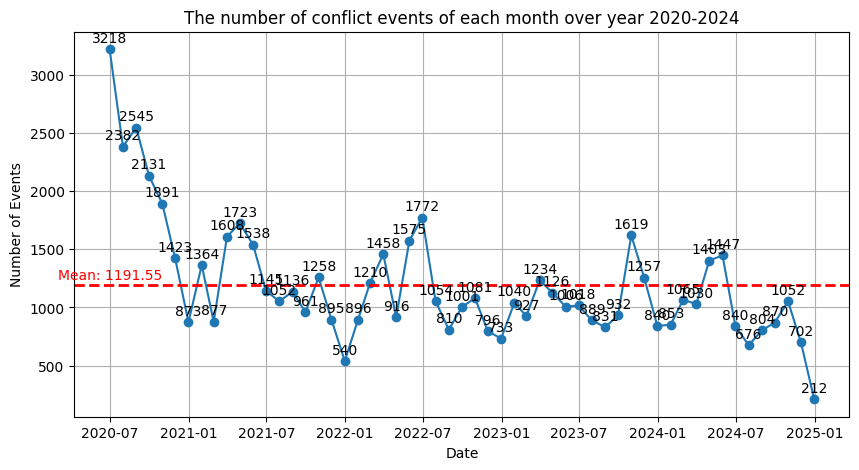

In [197]:
plt.figure(figsize=(10, 5))
plt.plot(monthly_events, marker='o', linestyle='-')
plt.title("The number of conflict events of each month over year 2020-2024")
plt.xlabel("Date")
plt.ylabel("Number of Events")
plt.grid()
for date, events in zip(monthly_events.index, monthly_events):
    plt.annotate(f"{events}", (date, events), textcoords="offset points", xytext=(0,5), ha='center')
plt.axhline(y=monthly_events.mean(), color='r', linestyle='--', linewidth=2)
plt.text(monthly_events.index[0], monthly_events.mean() + 50, 
         f"Mean: {monthly_events.mean():.2f}", color='r', fontsize=10, ha='center')
plt.savefig('D:/Umass/MTH522/Report/project2/pic1.jpg', dpi=300)
plt.show()

In [21]:
def trend_events(events):
    mth_events_demonstration=df_time_series[df_time_series['event_type'] == events].resample('M').size()
    plt.figure(figsize=(10, 5))
    plt.plot(mth_events_demonstration, marker='o', linestyle='-')
    plt.title(f"Trend of {events} Conflict Events Over Time")
    plt.xlabel("Date")
    plt.ylabel("Number of Events")
    plt.grid()
    for date, events in zip(mth_events_demonstration.index, mth_events_demonstration):
        plt.annotate(f"{events}", (date, events), textcoords="offset points", xytext=(0,5), ha='center')
    plt.axhline(y=mth_events_demonstration.mean(), color='r', linestyle='--', linewidth=2)
    plt.show()

C:\Users\taing\AppData\Local\Temp\ipykernel_35576\329387212.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mth_events_demonstration=df_time_series[df_time_series['event_type'] == events].resample('M').size()


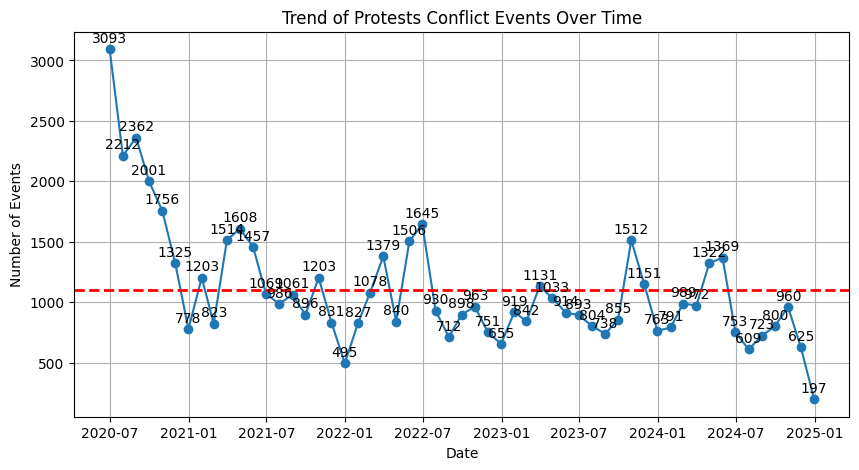

In [22]:
trend_events('Protests')

C:\Users\taing\AppData\Local\Temp\ipykernel_35576\329387212.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mth_events_demonstration=df_time_series[df_time_series['event_type'] == events].resample('M').size()


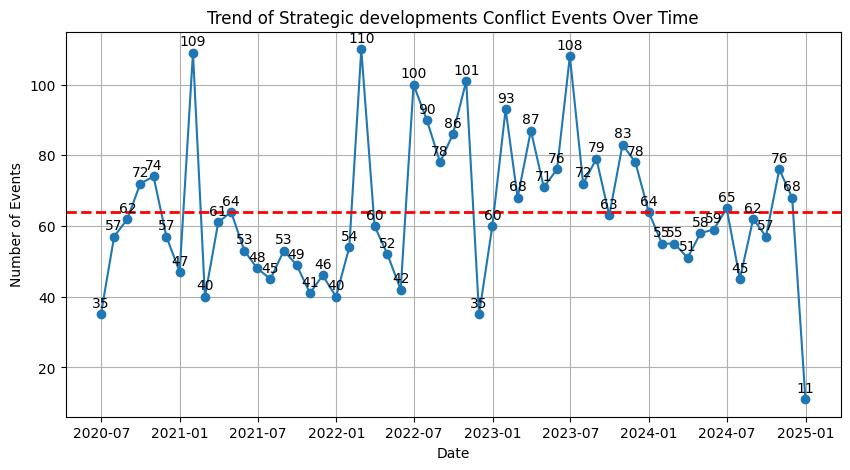

In [23]:
trend_events('Strategic developments')

C:\Users\taing\AppData\Local\Temp\ipykernel_35576\329387212.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mth_events_demonstration=df_time_series[df_time_series['event_type'] == events].resample('M').size()


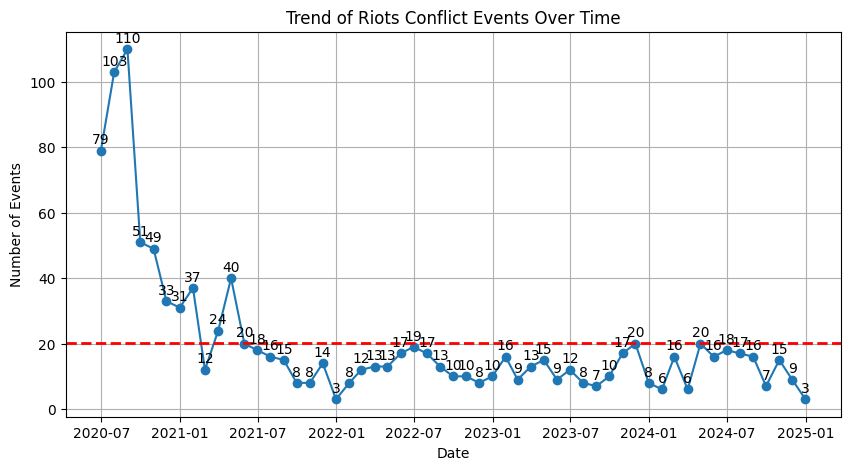

In [24]:
trend_events('Riots')

In [193]:
df_time_series['month'] = df_time_series.index.month

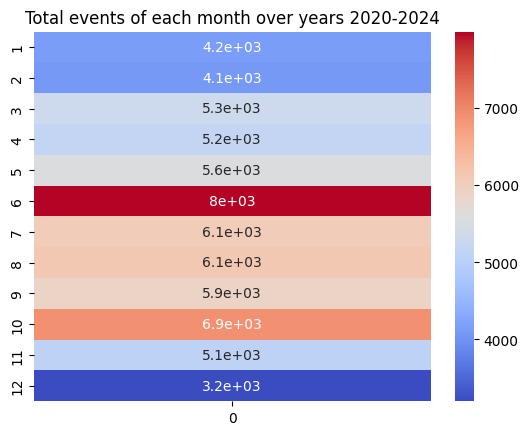

In [195]:
monthly_counts = df_time_series.groupby('month').size()

sns.heatmap(monthly_counts.values.reshape(-1, 1), annot=True, cmap='coolwarm', yticklabels=[i for i in range(1,13)])
plt.title('Total events of each month over years 2020-2024')
plt.savefig('D:/Umass/MTH522/Report/project2/pic2.jpg', dpi=300)
plt.show()

## Check stationality

In [21]:
from statsmodels.tsa.stattools import adfuller, kpss, zivot_andrews
from arch.unitroot import PhillipsPerron

In [11]:
def check_stationarity(timeseries):
    result = adfuller(timeseries.values.flatten())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [12]:
check_stationarity(monthly_events)

ADF Statistic: -3.406784
p-value: 0.010730


## Check Trend, Seasonality, Residual

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [179]:
decomposition = seasonal_decompose(monthly_events, model='additive')

In [180]:
# Extracting the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

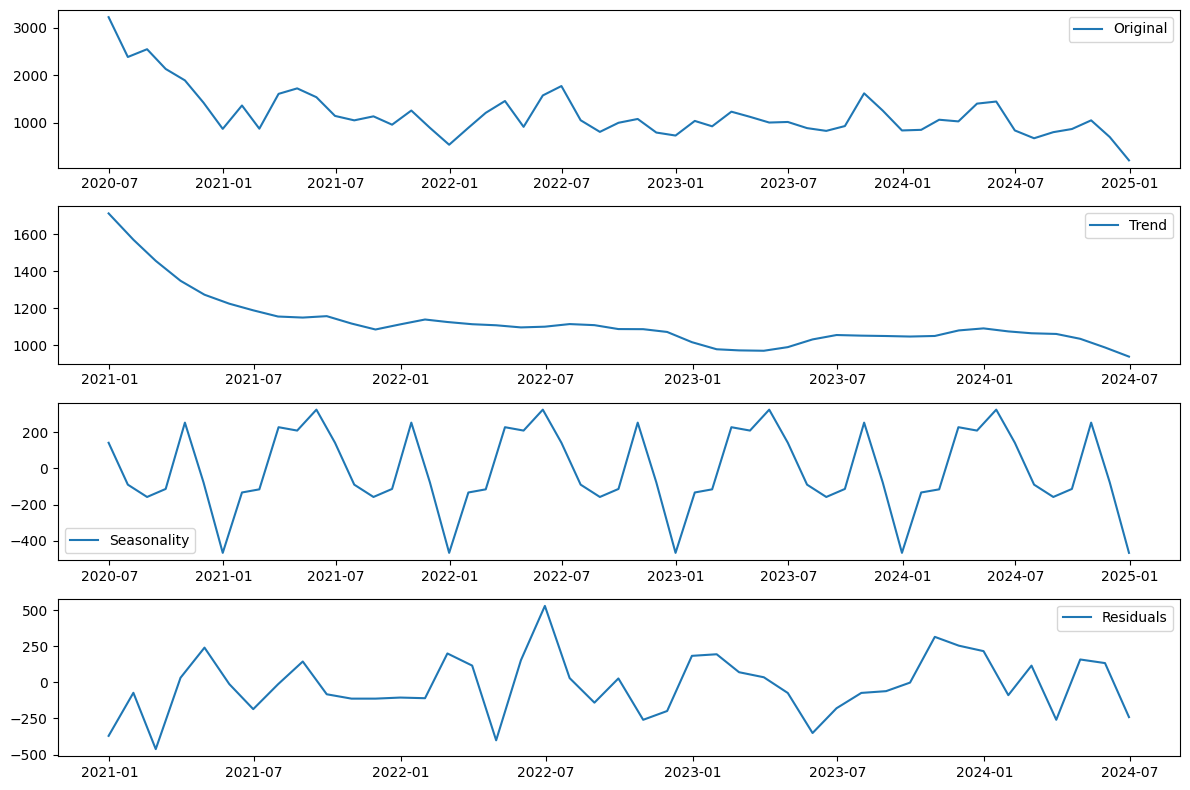

In [196]:
# Plotting the components
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(monthly_events, label='Original')
plt.legend(loc='best')
plt.savefig('D:/Umass/MTH522/Report/project2/Original.jpg', dpi=300)
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.savefig('D:/Umass/MTH522/Report/project2/trend.jpg', dpi=300)
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.savefig('D:/Umass/MTH522/Report/project2/seasonality.jpg', dpi=300)
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.savefig('D:/Umass/MTH522/Report/project2/Residual.jpg', dpi=300)
plt.tight_layout()